In [78]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, accuracy_score, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

In [61]:
df = pd.read_csv("../Data/Main_df.csv")
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.tail()

,Date,BTC,BTC_Volume,BTC_count,ETH,ETH_Volume,ETH_count,dxy,US_M2,EA_M2,CN_M2,reward,days_since_halving,fed_funds_rate
6269,2025-06-07,105615.626309,3.836503e+10,1.987610e+07,NaN,NaN,NaN,122.859,21862.5,1.087614e+13,1.935492e+14,3.125,413.0,4.33
6270,2025-06-08,105793.650228,3.662623e+10,1.987611e+07,NaN,NaN,NaN,122.859,21862.5,1.087614e+13,1.935492e+14,3.125,414.0,4.33
6271,2025-06-09,110294.099106,5.590319e+10,1.987695e+07,NaN,NaN,NaN,122.859,21862.5,1.087614e+13,1.935492e+14,3.125,415.0,4.33
6272,2025-06-10,110257.237712,5.470010e+10,1.987801e+07,NaN,NaN,NaN,122.859,21862.5,1.087614e+13,1.935492e+14,3.125,416.0,4.33
6273,2025-06-11,108686.627682,5.084266e+10,1.987749e+07,NaN,NaN,NaN,122.859,21862.5,1.087614e+13,1.935492e+14,3.125,417.0,4.33


In [110]:
df1=df[["days_since_halving",'Date','BTC','reward']]
df1['log_BTC'] = np.log(df1['BTC'])
df1=df1.dropna()
df1=df1.reset_index()
df1.head()

C:\Users\deepe\AppData\Local\Temp\ipykernel_47348\573367563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['log_BTC'] = np.log(df1['BTC'])


,index,days_since_halving,Date,BTC,reward,log_BTC
0,1010,0.0,2012-11-28,12.377134,25.0,2.515851
1,1011,0.0,2012-11-28,12.377134,25.0,2.515851
2,1012,1.0,2012-11-29,12.450000,25.0,2.521721
3,1013,1.0,2012-11-29,12.450000,25.0,2.521721
4,1014,2.0,2012-11-30,12.605554,25.0,2.534137


<Axes: title={'center': 'Log of BTC Price Over Time'}>

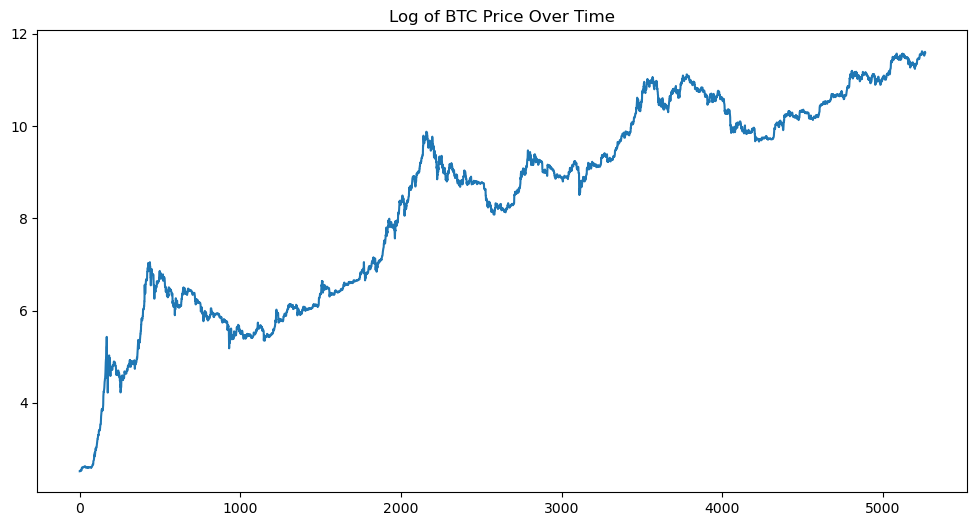

In [111]:
df1['log_BTC'].plot(figsize=(12, 6), title='Log of BTC Price Over Time')

In [112]:
df1["days_total"]=range(len(df1))
df1.head()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total
0,1010,0.0,2012-11-28,12.377134,25.0,2.515851,0
1,1011,0.0,2012-11-28,12.377134,25.0,2.515851,1
2,1012,1.0,2012-11-29,12.450000,25.0,2.521721,2
3,1013,1.0,2012-11-29,12.450000,25.0,2.521721,3
4,1014,2.0,2012-11-30,12.605554,25.0,2.534137,4


In [113]:
df1.describe()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total
count,5264.000000,5264.000000,5264,5264.000000,5264.000000,5264.000000,5264.000000
mean,3641.500000,654.868731,2019-02-07 20:14:02.553191680,18733.724201,13.399387,8.364140,2631.500000
min,1010.000000,0.000000,2012-11-28 00:00:00,12.377134,3.125000,2.515851,0.000000
25%,2325.750000,290.000000,2015-12-19 18:00:00,588.778992,6.250000,6.378051,1315.750000
50%,3641.500000,627.000000,2019-01-18 12:00:00,7548.948862,12.500000,8.929164,2631.500000
75%,4957.250000,1007.000000,2022-03-02 06:00:00,29001.719822,25.000000,10.275110,3947.250000
max,6273.000000,1439.000000,2025-06-11 00:00:00,111673.284019,25.000000,11.623333,5263.000000
std,1519.730239,409.082216,NaN,24824.110487,8.005029,2.208275,1519.730239


In [114]:
df1['day^2']=df1['days_total']**2
df1['day^3']=df1['days_total']**3
df1['day^4']=df1['days_total']**4

df1["Sin1"]= np.sin(2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos1"]= np.cos(2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin2"]= np.sin(2* 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos2"]= np.cos(2* 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin3"]= np.sin(3 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos3"]= np.cos(3 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin4"]= np.sin(4 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos4"]= np.cos(4 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin5"]= np.sin(5 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos5"]= np.cos(5 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin6"]= np.sin(6 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos6"]= np.cos(6 * 2 * np.pi * df1["days_since_halving"] / 1439)

df1['SinY1'] = np.sin(2 * np.pi * df1['days_total'] / 365.25)
df1['CosY1'] = np.cos(2 * np.pi * df1['days_total'] / 365.25)
df1['SinY2'] = np.sin(2 * 2 * np.pi * df1['days_total'] / 365.25)
df1['CosY2'] = np.cos(2 * 2 * np.pi * df1['days_total'] / 365.25)
df1['SinY3'] = np.sin(3 * 2 * np.pi * df1['days_total'] / 365.25) 
df1['CosY3'] = np.cos(3 * 2 * np.pi * df1['days_total'] / 365.25)

df1.head()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total,day^2,day^3,day^4,...,Sin5,Cos5,Sin6,Cos6,SinY1,CosY1,SinY2,CosY2,SinY3,CosY3
0,1010,0.0,2012-11-28,12.377134,25.0,2.515851,0,0,0,0,...,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,1011,0.0,2012-11-28,12.377134,25.0,2.515851,1,1,1,1,...,0.00000,1.000000,0.000000,1.000000,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669
2,1012,1.0,2012-11-29,12.450000,25.0,2.521721,2,4,8,16,...,0.02183,0.999762,0.026195,0.999657,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678
3,1013,1.0,2012-11-29,12.450000,25.0,2.521721,3,9,27,81,...,0.02183,0.999762,0.026195,0.999657,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039
4,1014,2.0,2012-11-30,12.605554,25.0,2.534137,4,16,64,256,...,0.04365,0.999047,0.052372,0.998628,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769


In [133]:
df1['day reward'] = df1['days_total'] * df1['reward']
df1['day^2 reward']= df1['day^2'] * df1['reward']

df1['Sin1 reward'] = df1['Sin1'] * df1['reward']
df1['Cos1 reward'] = df1['Cos1'] * df1['reward']
df1['Sin2 reward'] = df1['Sin2'] * df1['reward']
df1['Cos2 reward'] = df1['Cos2'] * df1['reward']
df1['Sin3 reward'] = df1['Sin3'] * df1['reward']
df1['Cos3 reward'] = df1['Cos3'] * df1['reward']
df1['Sin4 reward'] = df1['Sin4'] * df1['reward']
df1['Cos4 reward'] = df1['Cos4'] * df1['reward']

df1.tail()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total,day^2,day^3,day^4,...,day reward,day^2 reward,Sin1 reward,Cos1 reward,Sin2 reward,Cos2 reward,Sin3 reward,Cos3 reward,Sin4 reward,Cos4 reward
5259,6269,413.0,2025-06-07,105615.626309,3.125,11.567562,5259,27657081,145448588979,764914129440561,...,16434.375,8.642838e+07,3.040911,-0.720060,-1.401368,-2.793169,-2.395107,2.007259,2.505125,1.868147
5260,6270,414.0,2025-06-08,105793.650228,3.125,11.569246,5260,27667600,145531576000,765496089760000,...,16437.500,8.646125e+07,3.037738,-0.733331,-1.425706,-2.780825,-2.368609,2.038460,2.537369,1.824111
5261,6271,415.0,2025-06-09,110294.099106,3.125,11.610906,5261,27678121,145614594581,766078382090641,...,16440.625,8.649413e+07,3.034507,-0.746588,-1.449936,-2.768269,-2.341704,2.069311,2.568840,1.779519
5262,6272,416.0,2025-06-10,110257.237712,3.125,11.610571,5262,27688644,145697644728,766661006558736,...,16443.750,8.652701e+07,3.031218,-0.759830,-1.474055,-2.755501,-2.314398,2.099806,2.599526,1.734384
5263,6273,417.0,2025-06-11,108686.627682,3.125,11.596224,5263,27699169,145780726447,767243963290561,...,16446.875,8.655990e+07,3.027872,-0.773058,-1.498061,-2.742524,-2.286695,2.129942,2.629420,1.688720


# Model 0 with trend alone

time alone

In [119]:
X = df1[["days_total"]]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.8372, test RMSE: 0.6160
2709 365
Fold 4 → train RMSE: 0.8042, test RMSE: 0.4605
3074 365
Fold 5 → train RMSE: 0.7671, test RMSE: 0.5900
3439 365
Fold 6 → train RMSE: 0.7425, test RMSE: 0.4936
3804 365
Fold 7 → train RMSE: 0.7181, test RMSE: 0.8136
4169 365
Fold 8 → train RMSE: 0.7195, test RMSE: 1.4247
4534 365
Fold 9 → train RMSE: 0.7703, test RMSE: 0.9068
4899 365
Fold 10 → train RMSE: 0.7713, test RMSE: 0.5713
Average Train RMSE: 0.7662834164542693
Average Test RMSE: 0.7345746072255226


time and time^2

In [120]:
X = df1[["days_total",'day^2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.8129, test RMSE: 1.2361
2709 365
Fold 4 → train RMSE: 0.8038, test RMSE: 0.5377
3074 365
Fold 5 → train RMSE: 0.7649, test RMSE: 0.4366
3439 365
Fold 6 → train RMSE: 0.7312, test RMSE: 0.8544
3804 365
Fold 7 → train RMSE: 0.7176, test RMSE: 0.7455
4169 365
Fold 8 → train RMSE: 0.7084, test RMSE: 1.0687
4534 365
Fold 9 → train RMSE: 0.7118, test RMSE: 0.2788
4899 365
Fold 10 → train RMSE: 0.6889, test RMSE: 0.4420
Average Train RMSE: 0.7424404790573828
Average Test RMSE: 0.699968910268155


# Model 1: Trend and seasonality from halving cycle

In [91]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.4828, test RMSE: 0.1833
2709 365
Fold 4 → train RMSE: 0.4536, test RMSE: 1.0935
3074 365
Fold 5 → train RMSE: 0.4749, test RMSE: 0.7839
3439 365
Fold 6 → train RMSE: 0.4759, test RMSE: 0.5760
3804 365
Fold 7 → train RMSE: 0.4704, test RMSE: 0.9245
4169 365
Fold 8 → train RMSE: 0.4789, test RMSE: 0.3759
4534 365
Fold 9 → train RMSE: 0.4711, test RMSE: 0.6064
4899 365
Fold 10 → train RMSE: 0.4671, test RMSE: 0.3542
Average Train RMSE: 0.47182900007866113
Average Test RMSE: 0.6122181226013592


Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.3708, test RMSE: 0.5864


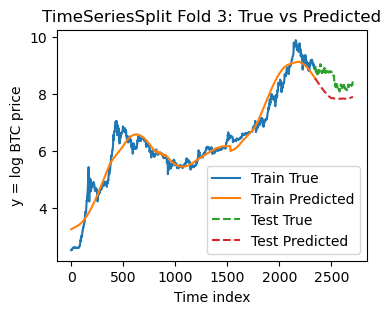

2709 365
Fold 4 → train RMSE: 0.3637, test RMSE: 0.3612


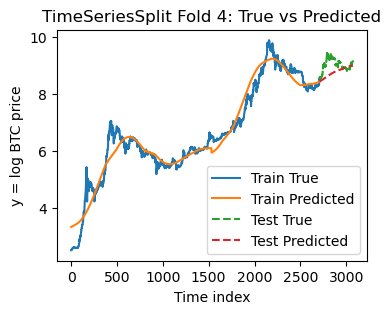

3074 365
Fold 5 → train RMSE: 0.3549, test RMSE: 0.3298


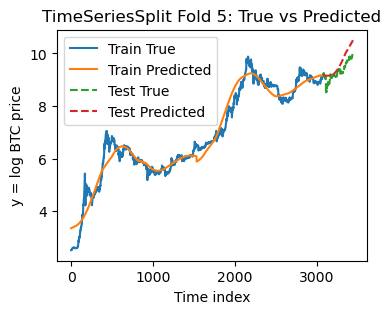

3439 365
Fold 6 → train RMSE: 0.3436, test RMSE: 1.0557


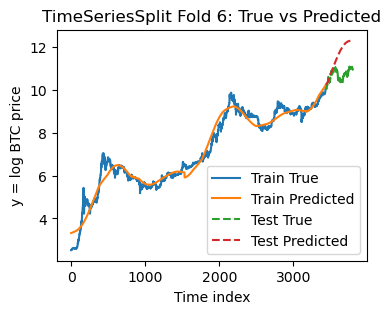

3804 365
Fold 7 → train RMSE: 0.3890, test RMSE: 0.6824


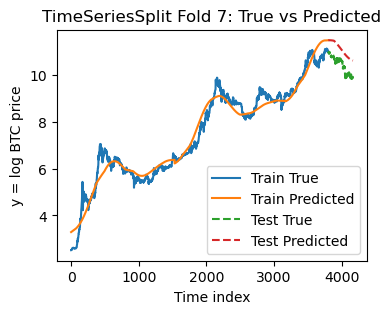

4169 365
Fold 8 → train RMSE: 0.3905, test RMSE: 0.2526


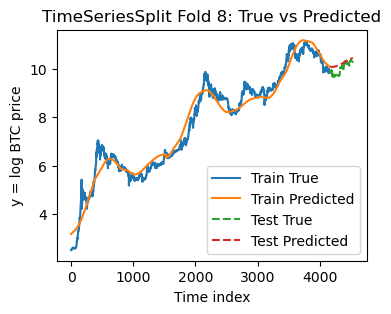

4534 365
Fold 9 → train RMSE: 0.3782, test RMSE: 0.5386


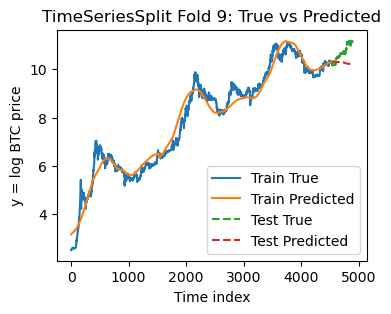

4899 365
Fold 10 → train RMSE: 0.3809, test RMSE: 0.4139


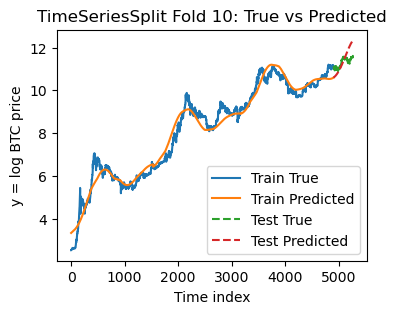

Average Train RMSE: 0.3714522819707317
Average Test RMSE: 0.5275842398859905


In [99]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1', 'Sin2', 'Cos2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    plt.figure(figsize=(4, 3))
    # training: solid lines
    plt.plot(train_idx, y_train,      label="Train True")
    plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    plt.plot(test_idx, y_test,        '--', label="Test True")
    plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    plt.legend()
    plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("y = log BTC price")
    plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

In [93]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1', 'Sin2', 'Cos2', 'Sin3', 'Cos3']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.3661, test RMSE: 0.7164
2709 365
Fold 4 → train RMSE: 0.3626, test RMSE: 0.3138
3074 365
Fold 5 → train RMSE: 0.3503, test RMSE: 0.3790
3439 365
Fold 6 → train RMSE: 0.3417, test RMSE: 1.0444
3804 365
Fold 7 → train RMSE: 0.3834, test RMSE: 0.7543
4169 365
Fold 8 → train RMSE: 0.3884, test RMSE: 0.2203
4534 365
Fold 9 → train RMSE: 0.3751, test RMSE: 0.5847
4899 365
Fold 10 → train RMSE: 0.3804, test RMSE: 0.4247
Average Train RMSE: 0.3684945066118992
Average Test RMSE: 0.5546954023753636


In [98]:
X = df1[["days_total", 'Sin1', 'Cos1', 'Sin2', 'Cos2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.3727, test RMSE: 0.4079
2709 365
Fold 4 → train RMSE: 0.3646, test RMSE: 0.4424
3074 365
Fold 5 → train RMSE: 0.3618, test RMSE: 0.1755
3439 365
Fold 6 → train RMSE: 0.3462, test RMSE: 0.9149
3804 365
Fold 7 → train RMSE: 0.3995, test RMSE: 1.0084
4169 365
Fold 8 → train RMSE: 0.4428, test RMSE: 0.9842
4534 365
Fold 9 → train RMSE: 0.4756, test RMSE: 0.5506
4899 365
Fold 10 → train RMSE: 0.4738, test RMSE: 1.0412
Average Train RMSE: 0.4046189337712763
Average Test RMSE: 0.690630903184698


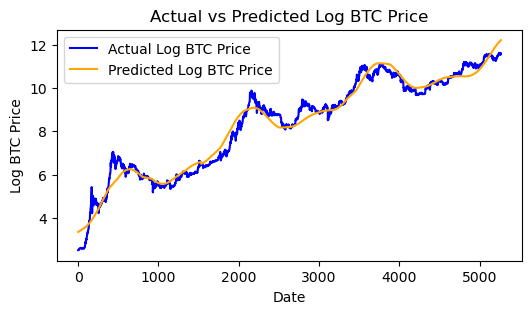

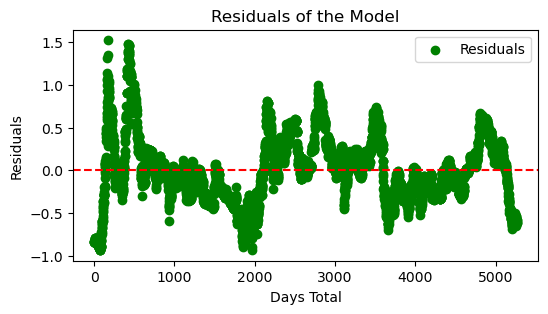

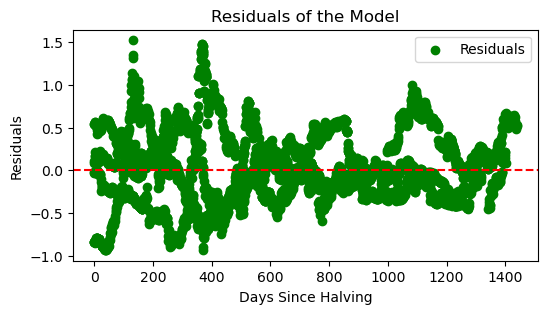

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_BTC   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 2.854e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:22:20   Log-Likelihood:                -2390.5
No. Observations:                5264   AIC:                             4795.
Df Residuals:                    5257   BIC:                             4841.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8364      0.016    233.152      0.000       3.804       3.869
days_total     0.0023   1.45e-05    159.554      0.000       0.002       0.002
day^2      -1.724e-07   2.68e-09    -64.374      0.000   -1.78e-07   -1.67e-07
Sin1           0.6087      0.008     80.732      0.000       0.594       0.624
Cos1          -0.3586      0.008    -45.630      0.000      -0.374      -0.343
Sin2          -0.3281      0.007    -44.576      0.000      -0.343      -0.314
Cos2          -0.1209      0.008    -15.859      0.000      -0.136      -0.106
==============================================================================
Omnibus:                      193.426   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.697
Skew:                           0.424   Prob(JB):                     1.09e-51
Kurtosis:                       3.592   Cond. No.                     3.92e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1', 'Sin2', 'Cos2']]
y= df1["log_BTC"]
X= sm.add_constant(X)  # Adding a constant term for the intercept

model0=sm.OLS(y, X).fit()
y_pred = model0.predict(X)

plt.figure(figsize=(6, 3))
plt.plot(df1['days_total'], y, label='Actual Log BTC Price', color='blue')
plt.plot(df1['days_total'], y_pred, label='Predicted Log BTC Price', color='orange')
plt.title('Actual vs Predicted Log BTC Price')
plt.xlabel('Date')
plt.ylabel('Log BTC Price')
plt.legend()
plt.show()

residues = y - y_pred
plt.figure(figsize=(6, 3))
plt.scatter(df1['days_total'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Total')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(df1['days_since_halving'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Since Halving')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()


model0.summary()

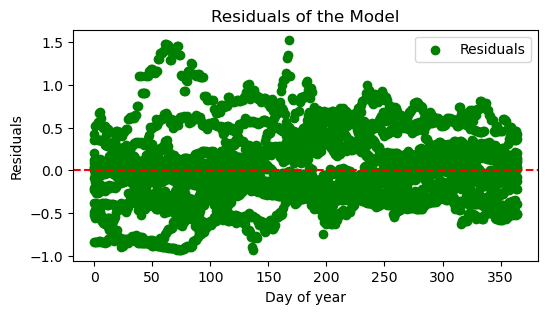

In [103]:
X['Day_of_Year']=X['days_total'] % 365
plt.figure(figsize=(6, 3))
plt.scatter(X['Day_of_Year'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Day of year')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

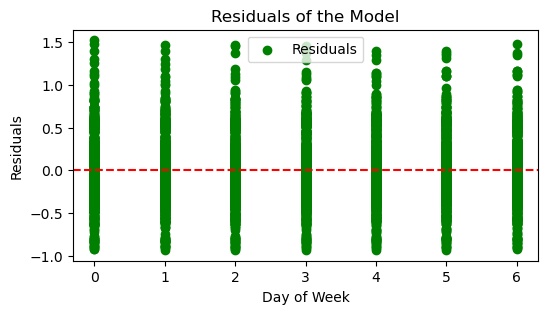

In [104]:
X['Day_of_Week']=X['days_total'] % 7
plt.figure(figsize=(6, 3))
plt.scatter(X['Day_of_Week'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Day of Week')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

# Model 2: Trend, Seasonality from halving cycle and yearly seasonality

In [100]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1', 'Sin2', 'Cos2', 'SinY1', 'CosY1']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.3665, test RMSE: 0.6095
2709 365
Fold 4 → train RMSE: 0.3601, test RMSE: 0.3241
3074 365
Fold 5 → train RMSE: 0.3485, test RMSE: 0.3362
3439 365
Fold 6 → train RMSE: 0.3376, test RMSE: 1.0414
3804 365
Fold 7 → train RMSE: 0.3780, test RMSE: 0.7228
4169 365
Fold 8 → train RMSE: 0.3838, test RMSE: 0.3062
4534 365
Fold 9 → train RMSE: 0.3740, test RMSE: 0.5523
4899 365
Fold 10 → train RMSE: 0.3788, test RMSE: 0.3950
Average Train RMSE: 0.36591614788992827
Average Test RMSE: 0.5359520977638198


# Model 3: Adjust based on reduced reward

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.3538, test RMSE: 0.7902


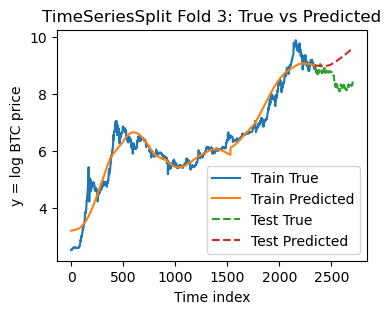

2709 365
Fold 4 → train RMSE: 0.3671, test RMSE: 0.3197


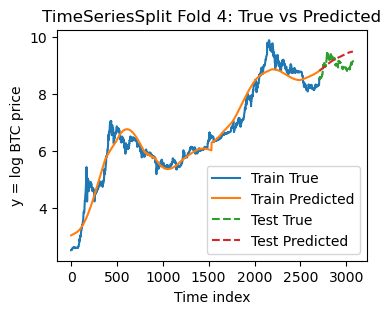

3074 365
Fold 5 → train RMSE: 0.3565, test RMSE: 0.5035


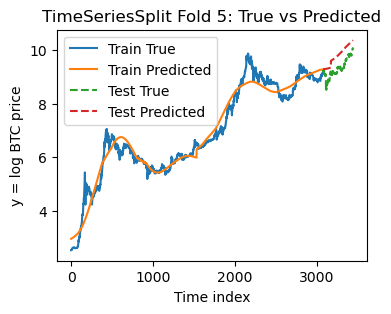

3439 365
Fold 6 → train RMSE: 0.3533, test RMSE: 0.3209


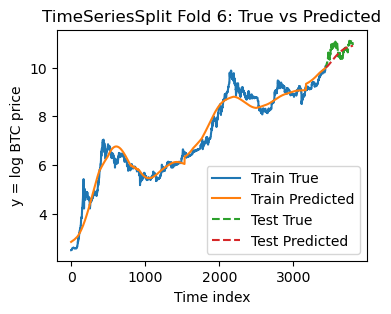

3804 365
Fold 7 → train RMSE: 0.3485, test RMSE: 0.7056


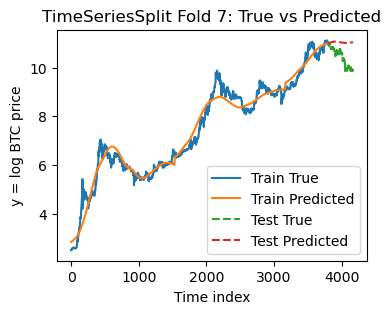

4169 365
Fold 8 → train RMSE: 0.3638, test RMSE: 0.7467


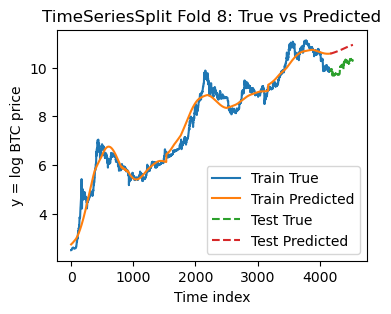

4534 365
Fold 9 → train RMSE: 0.3776, test RMSE: 0.3339


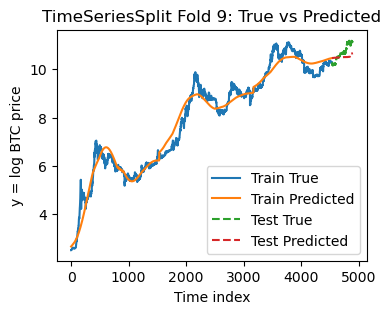

4899 365
Fold 10 → train RMSE: 0.3727, test RMSE: 0.3330


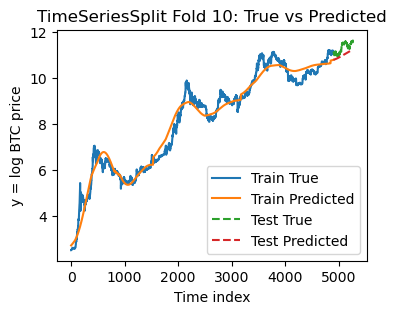

Average Train RMSE: 0.36163942554583306
Average Test RMSE: 0.5066901107521082


In [131]:
X = df1[["days_total",'day^2', 'Sin1 reward', 'Cos1 reward', 'Sin2 reward', 'Cos2 reward']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    plt.figure(figsize=(4, 3))
    # training: solid lines
    plt.plot(train_idx, y_train,      label="Train True")
    plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    plt.plot(test_idx, y_test,        '--', label="Test True")
    plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    plt.legend()
    plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("y = log BTC price")
    plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.3534, test RMSE: 0.3837


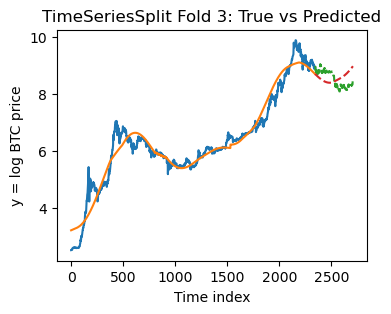

2709 365
Fold 4 → train RMSE: 0.3531, test RMSE: 0.5276


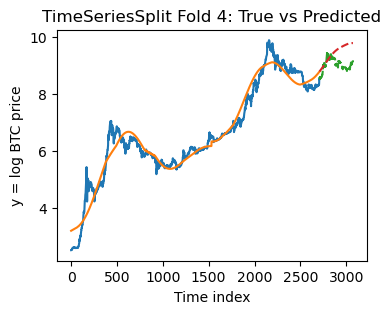

3074 365
Fold 5 → train RMSE: 0.3522, test RMSE: 0.2434


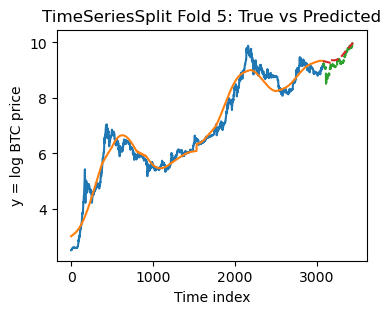

3439 365
Fold 6 → train RMSE: 0.3390, test RMSE: 0.3988


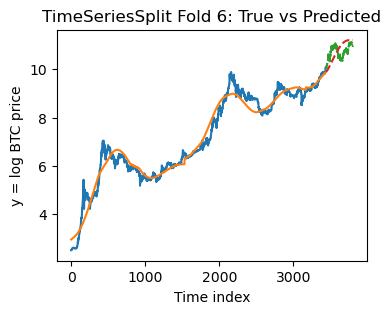

3804 365
Fold 7 → train RMSE: 0.3432, test RMSE: 0.4389


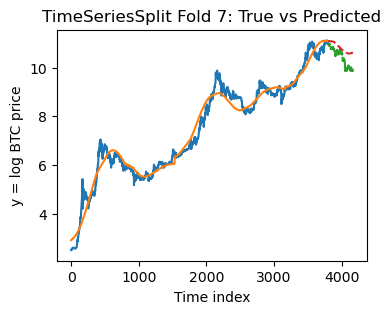

4169 365
Fold 8 → train RMSE: 0.3396, test RMSE: 0.7610


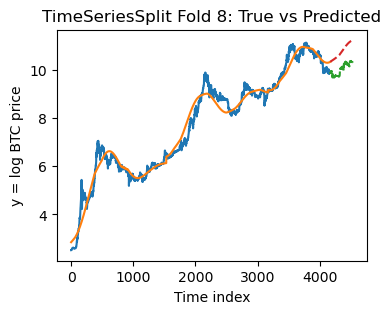

4534 365
Fold 9 → train RMSE: 0.3531, test RMSE: 0.4528


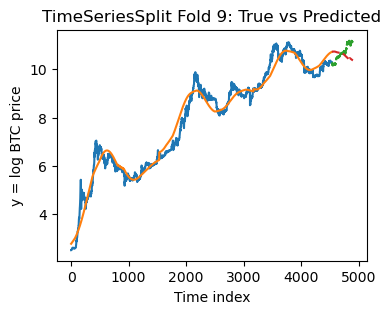

4899 365
Fold 10 → train RMSE: 0.3596, test RMSE: 0.5428


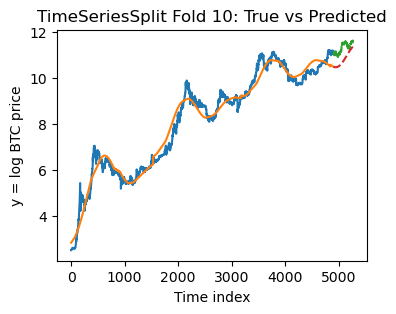

Average Train RMSE: 0.34916691452082577
Average Test RMSE: 0.4686204177102266


In [143]:
X = df1[["days_total",'day^2','Sin1 reward', 'Cos1 reward', 'Sin2', 'Cos2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    plt.figure(figsize=(4, 3))
    # training: solid lines
    plt.plot(train_idx, y_train,      label="Train True")
    plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    plt.plot(test_idx, y_test,        '--', label="Test True")
    plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("y = log BTC price")
    plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

# Final model for Trend and Seasonality

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2344 365
Fold 3 → train RMSE: 0.3534, test RMSE: 0.3837


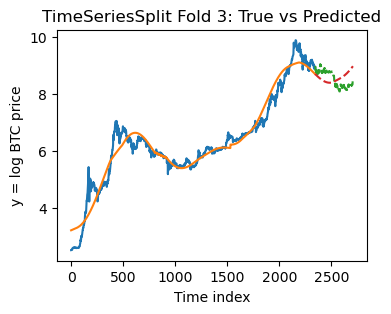

2709 365
Fold 4 → train RMSE: 0.3531, test RMSE: 0.5276


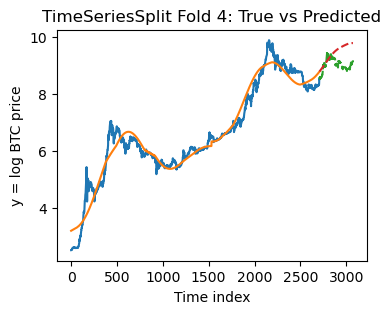

3074 365
Fold 5 → train RMSE: 0.3522, test RMSE: 0.2434


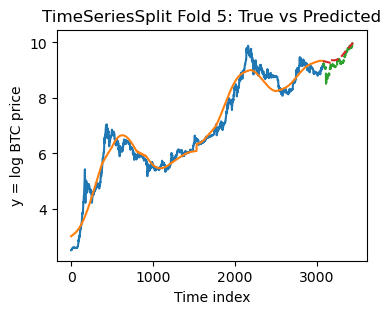

3439 365
Fold 6 → train RMSE: 0.3390, test RMSE: 0.3988


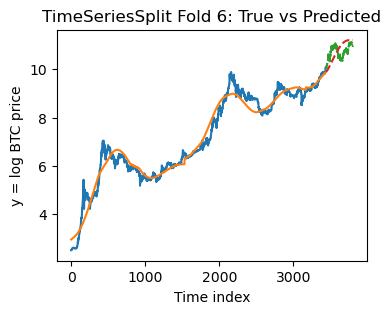

3804 365
Fold 7 → train RMSE: 0.3432, test RMSE: 0.4389


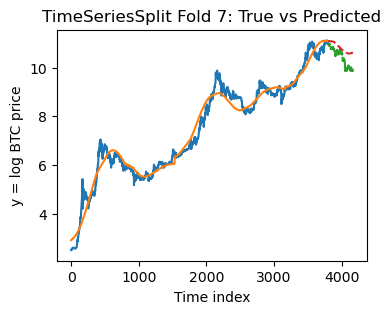

4169 365
Fold 8 → train RMSE: 0.3396, test RMSE: 0.7610


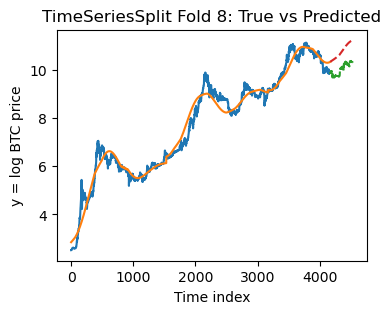

4534 365
Fold 9 → train RMSE: 0.3531, test RMSE: 0.4528


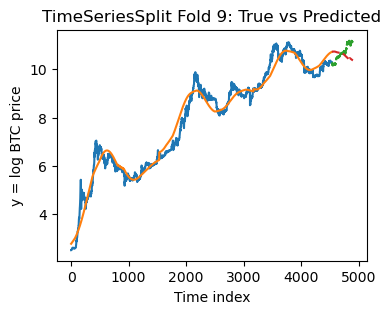

4899 365
Fold 10 → train RMSE: 0.3596, test RMSE: 0.5428


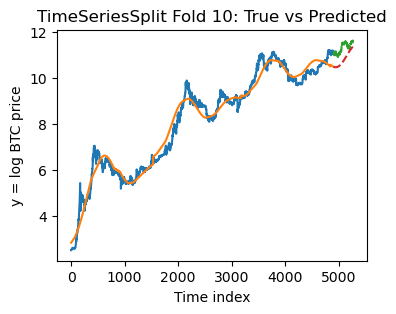

Average Train RMSE: 0.34916691452082577
Average Test RMSE: 0.4686204177102266


In [145]:
X = df1[["days_total",'day^2','Sin1 reward', 'Cos1 reward', 'Sin2', 'Cos2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    plt.figure(figsize=(4, 3))
    # training: solid lines
    plt.plot(train_idx, y_train,      label="Train True")
    plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    plt.plot(test_idx, y_test,        '--', label="Test True")
    plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("y = log BTC price")
    plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

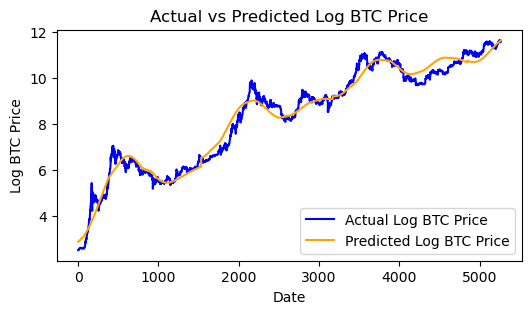

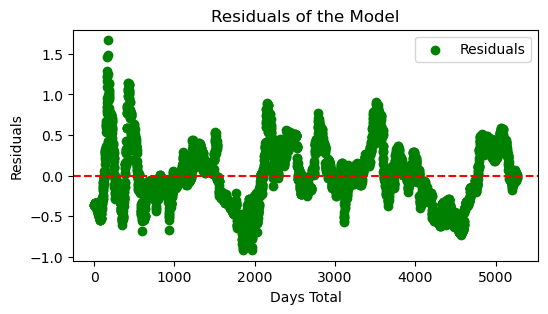

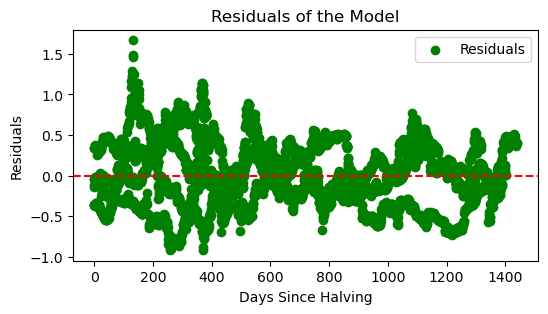

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_BTC   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 3.153e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:50:11   Log-Likelihood:                -2136.1
No. Observations:                5264   AIC:                             4286.
Df Residuals:                    5257   BIC:                             4332.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.6615      0.016    226.461      0.000       3.630       3.693
days_total      0.0025   1.42e-05    174.768      0.000       0.002       0.003
day^2       -2.014e-07   2.59e-09    -77.755      0.000   -2.06e-07   -1.96e-07
Sin1 reward     0.0399      0.000     84.769      0.000       0.039       0.041
Cos1 reward    -0.0246      0.000    -51.368      0.000      -0.026      -0.024
Sin2           -0.3025      0.007    -43.154      0.000      -0.316      -0.289
Cos2           -0.1697      0.007    -23.299      0.000      -0.184      -0.155
==============================================================================
Omnibus:                       63.366   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.402
Skew:                           0.270   Prob(JB):                     6.28e-15
Kurtosis:                       2.923   Cond. No.                     4.01e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.01e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [144]:
X = df1[["days_total",'day^2', 'Sin1 reward', 'Cos1 reward', 'Sin2', 'Cos2']]
y= df1["log_BTC"]
X= sm.add_constant(X)  # Adding a constant term for the intercept

model0=sm.OLS(y, X).fit()
y_pred = model0.predict(X)

plt.figure(figsize=(6, 3))
plt.plot(df1['days_total'], y, label='Actual Log BTC Price', color='blue')
plt.plot(df1['days_total'], y_pred, label='Predicted Log BTC Price', color='orange')
plt.title('Actual vs Predicted Log BTC Price')
plt.xlabel('Date')
plt.ylabel('Log BTC Price')
plt.legend()
plt.show()

residues = y - y_pred
plt.figure(figsize=(6, 3))
plt.scatter(df1['days_total'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Total')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(df1['days_since_halving'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Since Halving')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()


model0.summary()